# ***AMATRICE-VISSO-NORCIA 2016-2017*** seismic sequence (Central Appennines)

#### The aim is to ***create a seismic catalog using new artificial intelligence methods***, particularly ***PhaseNet*** (Zhu et al., 2019) and the ***Seisbench*** platform, which contains training datasets and other deep learning models for picking.

##### Let's start with the second task:
##### Picks P- and S- wave arrival times for each stations. To do so, we use the Seisbench Platform and use PhaseNet with the training coming from INSTANCE dataset.


##### The parameters to be specified will be:
##### 1. Directory of the experiment;
##### 2. Time interval;
##### 3. Pretrained model used.

In [4]:
#import libraries
import os
import glob
import numpy as np
from obspy import read, Stream
from seisbench.models import PhaseNet
from seisbench.util import stream_to_array
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import pandas as pd

In [4]:
#upload the DNN model and the pretraing data.
model = PhaseNet.from_pretrained("instance")

Downloading: 100%|█████████████████████████| 1.06M/1.06M [00:00<00:00, 5.16MB/s]


In [92]:
# Parametes
net = 'IV'
stat='CAMP'
year = 2016
start_day = 304
end_day = 304
# Lunghezza della finestra di analisi in secondi
wlength = 7200

base_path = f"/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveforms/{year}/{net}/{stat}"
paths = {
    "Z": os.path.join(base_path, "HHZ.D"),
    "N": os.path.join(base_path, "HHN.D"),
    "E": os.path.join(base_path, "HHE.D"),
}

In [93]:
#print (paths)

In [94]:
# Read files
def append_component_from_folder(folder, stream, year, start_day, end_day):
    for file in os.listdir(folder):
        if os.path.isfile(os.path.join(folder, file)):
            parts = file.split(".")
            file_year = int(parts[-2])  
            file_day = int(parts[-1])  
            if file_year == year and start_day <= file_day <= end_day:
                single_trace = read(os.path.join(folder, file)) 
                stream.append(single_trace[0]) 

# stream creation
combined_stream = Stream()
for component, path in paths.items():
    append_component_from_folder(path, combined_stream, year, start_day, end_day)

print("Stream combinato:")
print(combined_stream)

Stream combinato:
3 Trace(s) in Stream:
IV.CAMP..HHZ | 2016-10-30T00:00:00.000200Z - 2016-10-30T00:06:51.990200Z | 100.0 Hz, 41200 samples
IV.CAMP..HHN | 2016-10-30T00:00:00.000200Z - 2016-10-30T00:06:51.990200Z | 100.0 Hz, 41200 samples
IV.CAMP..HHE | 2016-10-30T00:00:00.000000Z - 2016-10-30T00:06:51.990000Z | 100.0 Hz, 41200 samples


In [95]:
#print(combined_stream.__str__(extended=True))

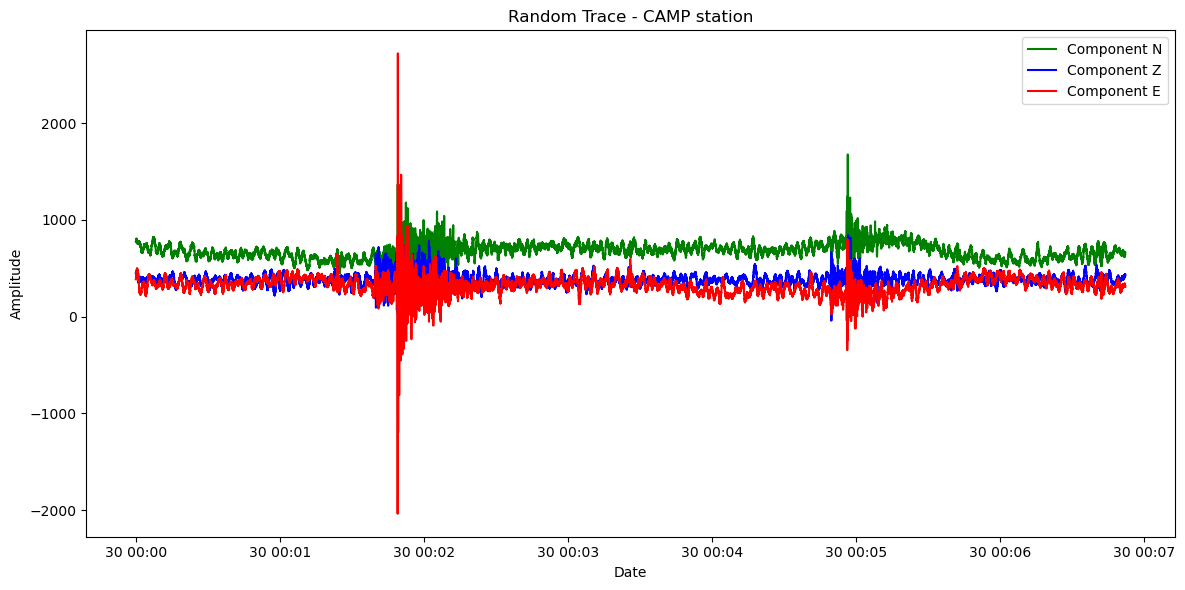

In [96]:
import random
from obspy import UTCDateTime

# Selezione casuale di un gruppo di 3 componenti consecutive (Z, N, E)
num_traces = len(combined_stream) // 3  # Ogni traccia ha 3 componenti
random_index = random.randint(0, num_traces - 1)
selected_traces = combined_stream[random_index * 3: (random_index + 1) * 3]

# Plot della traccia selezionata
plt.figure(figsize=(12, 6))

# Creazione dell'asse temporale in UTC
time = [UTCDateTime(t).datetime for t in selected_traces[0].times("timestamp")]

# Plot delle tre componenti con colori distintivi
plt.plot(time, selected_traces[1].data, color="green", label="Component N")
plt.plot(time, selected_traces[0].data, color="blue", label="Component Z")
plt.plot(time, selected_traces[2].data, color="red", label="Component E")

# Configurazione del grafico
plt.title(f"Random Trace - {stat} station")
plt.xlabel("Date")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")
plt.tight_layout()

# Mostra il plot
plt.savefig(f"random_trace_{stat}.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [97]:
#DEBUG duplicate trace
unique_traces = {}
for trace in combined_stream:
    key = (
        trace.stats.network,
        trace.stats.station,
        trace.stats.channel,
        int(trace.stats.starttime.timestamp),
        int(trace.stats.endtime.timestamp)
    )
    if key not in unique_traces:
        unique_traces[key] = trace

# New stream withoud duplicates
combined_stream = Stream(traces=list(unique_traces.values()))
print(f"Stream checked with {len(combined_stream)} unique traces.")

Stream pulito con 3 tracce uniche.


In [98]:
# First run of prediction using annotate function on seisbench
annotations = model.annotate(combined_stream)
print("\nAnnotations (time arrival):")
for i, annotation in enumerate(annotations):
    print(f"Annotation {i+1}: {annotation}")


Annotations (time arrival):
Annotation 1: IV.CAMP..PhaseNet_P | 2016-10-30T00:00:02.500000Z - 2016-10-30T00:06:49.490000Z | 100.0 Hz, 40700 samples
Annotation 2: IV.CAMP..PhaseNet_S | 2016-10-30T00:00:02.500000Z - 2016-10-30T00:06:49.490000Z | 100.0 Hz, 40700 samples
Annotation 3: IV.CAMP..PhaseNet_N | 2016-10-30T00:00:02.500000Z - 2016-10-30T00:06:49.490000Z | 100.0 Hz, 40700 samples


In [99]:
# convert annotations into discrete arrival times and define the picking probability
outputs = model.classify(combined_stream, batch_size=256, P_threshold=0.5, S_threshold=0.5).picks
Counter([p.phase for p in outputs])
Counter([s.phase for s in outputs])

Counter({'S': 3, 'P': 2})

In [100]:
# Print the picks
print("\nPredizioni di classificazione:")
for i, prediction in enumerate(outputs):
    print(f"Predictions {i+1}: {prediction}")


Predizioni di classificazione:
Predictions 1: IV.CAMP.	2016-10-30T00:01:23.730000Z	S
Predictions 2: IV.CAMP.	2016-10-30T00:01:39.680000Z	P
Predictions 3: IV.CAMP.	2016-10-30T00:01:48.690000Z	S
Predictions 4: IV.CAMP.	2016-10-30T00:04:49.310000Z	P
Predictions 5: IV.CAMP.	2016-10-30T00:04:55.860000Z	S


In [101]:
#convert the dictonary into a dataframe
#print(outputs.picks[0].__dict__)
pick_df = []
for p in outputs:
    pick_df.append({
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })
pick_df = pd.DataFrame(pick_df)

In [102]:
#Sort picks
pick_df.sort_values("timestamp")

,id,timestamp,prob,type
0,IV.CAMP.,2016-10-30 00:01:23.730,0.638396,s
1,IV.CAMP.,2016-10-30 00:01:39.680,0.961707,p
2,IV.CAMP.,2016-10-30 00:01:48.690,0.661504,s
3,IV.CAMP.,2016-10-30 00:04:49.310,0.970970,p
4,IV.CAMP.,2016-10-30 00:04:55.860,0.804244,s


In [103]:
#save picking
pick_df.to_csv(f'picks_{stat}.csv', index=False)

##### Sort the picking of all stations into a single file!
##### We'll obtain a list of picks sorted by time

In [1]:
#define input and output file
file_in="all_picks_2016.dat"
file_out="all_picks_2016_sort.dat"

In [2]:
#function to sort picks
def sort_seismic_picking(input_file, output_file):
    # Caricamento del file con header corretto
    df = pd.read_csv(input_file, sep=",")

    # Conversione della colonna timestamp in datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")

    # Rimozione delle righe con timestamp non validi (se presenti)
    df = df.dropna(subset=["timestamp"])

    # Ordinamento per timestamp
    df_sorted = df.sort_values(by="timestamp")

    # Salvataggio del file ordinato
    df_sorted.to_csv(output_file, index=False)
    print(f"Save file as: {output_file}")

In [5]:
#save file 
sort_seismic_picking(file_in,file_out)

Save file as: all_picks_2016_sort.dat
